In [1]:
import numpy as np
from pandas import pandas as pd
import time
import copy
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

In [2]:
dt = pd.read_csv("dataset_with_labels.csv", engine='python').drop('Unnamed: 0',axis=1).reset_index(drop=True)
data = copy.copy(dt)

data.head()

,subject_id,icustay_id,creatinine,age,arterial_pressure_systolic,arterial_pressure_systolic_delay,arterial_pressure_diastolic,arterial_pressure_diastolic_delay,heart_rate,heart_rate_delay,...,bilirubin,bilirubin_delay,c_reactive_protein,c_reactive_protein_delay,ethnicity,diagnosis,gender,creatinine_yesterday,creatinine_before_yesterday,label
0,77815,239231,0.6,58.363217,155.0,1800.0,75.0,1800.0,58.0,1800.0,...,NaN,NaN,NaN,NaN,WHITE,INTRACRANIAL HEMORRHAGE,M,0.7,0.6,2.0
1,77815,239231,0.6,58.363217,155.0,1800.0,75.0,1800.0,58.0,1800.0,...,NaN,NaN,NaN,NaN,WHITE,INTRACRANIAL HEMORRHAGE,M,NaN,0.7,2.0
2,31558,249349,0.6,52.688716,165.0,1440.0,75.0,1440.0,102.0,1440.0,...,NaN,NaN,NaN,NaN,WHITE,S/P BOATING ACCIDENT,M,NaN,NaN,2.0
3,31558,249349,0.6,52.688716,165.0,1440.0,75.0,1440.0,102.0,1440.0,...,NaN,NaN,NaN,NaN,WHITE,S/P BOATING ACCIDENT,M,0.7,0.7,0.0
4,31558,249349,0.6,52.688716,165.0,1440.0,75.0,1440.0,102.0,1440.0,...,NaN,NaN,NaN,NaN,WHITE,S/P BOATING ACCIDENT,M,0.6,0.6,2.0


In [3]:
data = dt
# Remove outliers
feat_names = ['creatinine', 
#               'creatinine_yesterday', 
#               'creatinine_before_yesterday', 
              'diagnosis',
              'arterial_pressure_systolic',  
              'age', 
              'gender', 
              'arterial_pressure_diastolic',
              'heart_rate',  
              'weight_daily', 
              'temperature',  
              'ph_blood', 
              'ethnicity']
              

# ['creatinine_yesterday', 'creatinine_before_yesterday',
#               'urea', 'potassium','gender', 'ethnicity', 'diagnosis', 'gender', 'ethnicity', '',
#               'platelet_count', 'ph_blood',
#               'creatinine', 'age', 'bilirubin']
# feat_names = feat_names + ['arterial_pressure_systolic_delay', 'arterial_pressure_diastolic_delay',
#                            'heart_rate_delay', 'weight_daily_delay', 'temperature_delay']
feat_lab = feat_names + ['label']
print('Initial data length: ', len(data))
data = data[feat_lab]

# Remove outliers
data = data[data['creatinine'] < 20]
# data = data[data['creatinine_yesterday'] < 20]
# data = data[data['creatinine_before_yesterday'] < 20]
# data = data[data['potassium'] > 1.2]
# data = data[data['ph_blood'] > 6]
data = data[data['age'] < 110]
# data = data[data['bilirubin'] < 20]
data['gender'] = data['gender'].map({'F': 1, 'M': 0})

# Remove Nan
for name in feat_names:
    try:
        data = data[np.isfinite(data[name])]
    except:
        print(name)
        data = data[data[name].isnull() == False]
print('\nTotal entries: ', len(data))
print(data.isnull().sum())

Initial data length:  36251
diagnosis
ethnicity

Total entries:  20248
creatinine                     0
diagnosis                      0
arterial_pressure_systolic     0
age                            0
gender                         0
arterial_pressure_diastolic    0
heart_rate                     0
weight_daily                   0
temperature                    0
ph_blood                       0
ethnicity                      0
label                          0
dtype: int64


In [4]:
data['ethnicity'].unique()



data['ethnicity'] = data['ethnicity'].map({'BLACK/AFRICAN AMERICAN': 'BLACK', 
                                           'WHITE': 'WHITE', 
                                           'UNKNOWN/NOT SPECIFIED': 'NaN',
                                           'HISPANIC/LATINO - DOMINICAN': 'OTHER', 
                                           'UNABLE TO OBTAIN': 'NaN',
                                           'PATIENT DECLINED TO ANSWER': 'NaN', 
                                           'ASIAN - CHINESE': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER', 
                                           'MULTI RACE ETHNICITY': 'OTHER',
                                           'WHITE - OTHER EUROPEAN': 'WHITE', 
                                           'OTHER': 'OTHER', 
                                           'PORTUGUESE': 'WHITE',
                                           'HISPANIC OR LATINO': 'OTHER', 
                                           'ASIAN': 'ASIAN', 
                                           'HISPANIC/LATINO - PUERTO RICAN': 'OTHER',
                                           'MIDDLE EASTERN': 'OTHER', 
                                           'ASIAN - KOREAN': 'ASIAN', 
                                           'BLACK/HAITIAN': 'BLACK',
                                           'ASIAN - OTHER': 'ASIAN', 
                                           'HISPANIC/LATINO - CUBAN': 'OTHER', 
                                           'ASIAN - FILIPINO': 'ASIAN',
                                           'BLACK/CAPE VERDEAN': 'BLACK', 
                                           'WHITE - BRAZILIAN': 'WHITE', 
                                           'ASIAN - ASIAN INDIAN': 'ASIAN',
                                           'WHITE - EASTERN EUROPEAN': 'WHITE', 
                                           'HISPANIC/LATINO - GUATEMALAN': 'OTHER',
                                           'ASIAN - VIETNAMESE': 'ASIAN', 
                                           'HISPANIC/LATINO - MEXICAN': 'OTHER',
                                           'WHITE - RUSSIAN': 'WHITE', 
                                           'BLACK/AFRICAN': 'BLACK', 
                                           'ASIAN - CAMBODIAN': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'OTHER'})
data['ethnicity'].unique()
data.tail()

,creatinine,diagnosis,arterial_pressure_systolic,age,gender,arterial_pressure_diastolic,heart_rate,weight_daily,temperature,ph_blood,ethnicity,label
35052,4.1,PROSTATE CANCER/SDA,91.0,67.499090,0,56.0,139.0,86.8,97.8,7.24,WHITE,0.0
35053,1.0,ABDOMINAL PAIN; HYPOTENSION,132.0,81.055932,1,31.0,97.0,87.1,98.1,7.29,WHITE,1.0
35054,1.7,HYPERTENSION,148.0,72.524046,0,50.0,74.0,123.0,98.9,7.42,WHITE,1.0
35059,1.4,FOURNIER'S GANGRENE,105.0,62.708193,0,47.0,87.0,90.5,98.8,7.26,WHITE,0.0
35060,1.7,CRITITCAL AORTIC STENOSIS,97.0,74.357404,1,46.0,72.0,122.6,98.4,7.39,WHITE,0.0


In [5]:
len(data['diagnosis'].unique())
diag_to_stay = ['PNEUMONIA', 'CONGESTIVE HEART FAILURE', 'SUBARACHNOID HEMORRHAGE',
               'INTRACRANIAL HEMORRHAGE', 'ALTERED MENTAL STATUS', 'CORONARY ARTERY DISEASE',
               'ABDOMINAL PAIN', 'CHEST PAIN', 'HYPOTENSION', 'ACUTE RENAL FAILURE',
               'RESPIRATORY FAILURE', 'GASTROINTESTINAL BLEED', 'PANCREATITIS', 'SEPSIS']
'YS' in data['diagnosis'].iloc[1]
for i in range(len(data['diagnosis'])):
    value = data['diagnosis'].iat[i]
    if 'FEVER' in value:
        data['diagnosis'].iat[i] = 'SEPSIS'
    elif 'DYSPNEA' in value or 'SHORTNESS OF BREATH' in value:
        data['diagnosis'].iat[i] = 'RESPIRATORY FAILURE'
    elif value not in diag_to_stay:
        data['diagnosis'].iat[i] = 'OTHER'
data['diagnosis'].unique()

array(['OTHER', 'SEPSIS', 'PNEUMONIA', 'PANCREATITIS',
       'INTRACRANIAL HEMORRHAGE', 'SUBARACHNOID HEMORRHAGE',
       'ABDOMINAL PAIN', 'CONGESTIVE HEART FAILURE', 'HYPOTENSION',
       'CHEST PAIN', 'CORONARY ARTERY DISEASE', 'ALTERED MENTAL STATUS',
       'RESPIRATORY FAILURE', 'GASTROINTESTINAL BLEED',
       'ACUTE RENAL FAILURE'], dtype=object)

In [6]:
print(feat_names)
data = pd.get_dummies(data)
data.head()

['creatinine', 'diagnosis', 'arterial_pressure_systolic', 'age', 'gender', 'arterial_pressure_diastolic', 'heart_rate', 'weight_daily', 'temperature', 'ph_blood', 'ethnicity']


,creatinine,arterial_pressure_systolic,age,gender,arterial_pressure_diastolic,heart_rate,weight_daily,temperature,ph_blood,label,...,diagnosis_PANCREATITIS,diagnosis_PNEUMONIA,diagnosis_RESPIRATORY FAILURE,diagnosis_SEPSIS,diagnosis_SUBARACHNOID HEMORRHAGE,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_NaN,ethnicity_OTHER,ethnicity_WHITE
2,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,2.0,...,0,0,0,0,0,0,0,0,0,1
3,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,2.0,...,0,0,0,0,0,0,0,0,0,1
5,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,2.0,...,0,0,0,0,0,0,0,0,0,1
6,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,0.0,...,0,0,0,0,0,0,0,0,0,1


## Model selection part

In [7]:
y = data['label']
feat_names = list(data)
feat_names.remove('label')
X = data[feat_names]
X.head()

,creatinine,arterial_pressure_systolic,age,gender,arterial_pressure_diastolic,heart_rate,weight_daily,temperature,ph_blood,diagnosis_ABDOMINAL PAIN,...,diagnosis_PANCREATITIS,diagnosis_PNEUMONIA,diagnosis_RESPIRATORY FAILURE,diagnosis_SEPSIS,diagnosis_SUBARACHNOID HEMORRHAGE,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_NaN,ethnicity_OTHER,ethnicity_WHITE
2,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,0,...,0,0,0,0,0,0,0,0,0,1
3,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,0,...,0,0,0,0,0,0,0,0,0,1
4,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,0,...,0,0,0,0,0,0,0,0,0,1
5,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,0,...,0,0,0,0,0,0,0,0,0,1
6,0.6,165.0,52.688716,0,75.0,102.0,110.0,98.599998,7.28,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
print(len(list(X)))
print(y.value_counts()/len(y))

29
2.0    0.626926
1.0    0.199921
0.0    0.173153
Name: label, dtype: float64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Split to three test sets
test_size = len(X_test) // 2
X_validation = X_test[0:test_size]
y_validation = y_test[0:test_size]

X_test = X_test[test_size:-1]
y_test = y_test[test_size:-1]

##### Train an adaboost classifier with random forests as base estimator on all features

In [10]:
def hyp_tuning(X_train, X_validation, y_train):
    # Initialize the classifier
    clf = AdaBoostClassifier(RandomForestClassifier(class_weight="balanced"))

    # Create cross-validation sets from the training data
    cv_sets = StratifiedShuffleSplit(n_splits=3, 
                                     test_size=0.1, 
                                     train_size=None, 
                                     random_state=42)

    # Create the parameters list you wish to tune
    parameters = {'n_estimators': [50],
                  'learning_rate': [0.2, 0.5]}

    # Make an fbeta_score scoring object
    scorer = make_scorer(fbeta_score, beta = 0.5, average = 'weighted')

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(clf, 
                            param_grid = parameters, 
                            scoring = scorer, 
                            cv = cv_sets, 
                            n_jobs = 1) #-1)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    best_predictions = best_clf.predict(X_validation)
    return best_clf, best_predictions

# Report the before-and-afterscores
start = time.time()

best_clf, best_predictions = hyp_tuning(X_train, X_validation, y_train)

end = time.time()

In [11]:
print("\nTime elapsed: ", (end - start)/60, " min")
print("\nBest classifier: ", best_clf)
conf = confusion_matrix(y_validation, best_predictions)
print("Confusion matrix")
pprint(conf)

print("\nClassification report")
print(classification_report(y_validation, best_predictions))


Time elapsed:  1.5897667805353801  min

Best classifier:  AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=0.5, n_estimators=50, random_state=None)
Confusion matrix
array([[  90,   97,  164],
       [  48,  156,  182],
       [ 138,  123, 1027]])

Classification report
             precision    recall  f1-score   support

        0.0       0.33      0.26      0.29       351
        1.0       0.41      0.40      0.41       386
        2.0       0.75      0.80      0.77      1288

avg / total       0.61      0.63      0.62      2025



### Final test set

In [12]:
best_predictions_test = best_clf.predict(X_test)
conf = confusion_matrix(y_test, best_predictions_test)

print("Confusion matrix")
pprint(conf)

print("\nClassification report")
print(classification_report(y_test, best_predictions_test))

Confusion matrix
array([[ 92,  83, 201],
       [ 71, 162, 184],
       [106, 126, 999]])

Classification report
             precision    recall  f1-score   support

        0.0       0.34      0.24      0.29       376
        1.0       0.44      0.39      0.41       417
        2.0       0.72      0.81      0.76      1231

avg / total       0.59      0.62      0.60      2024



### Principal component analysis

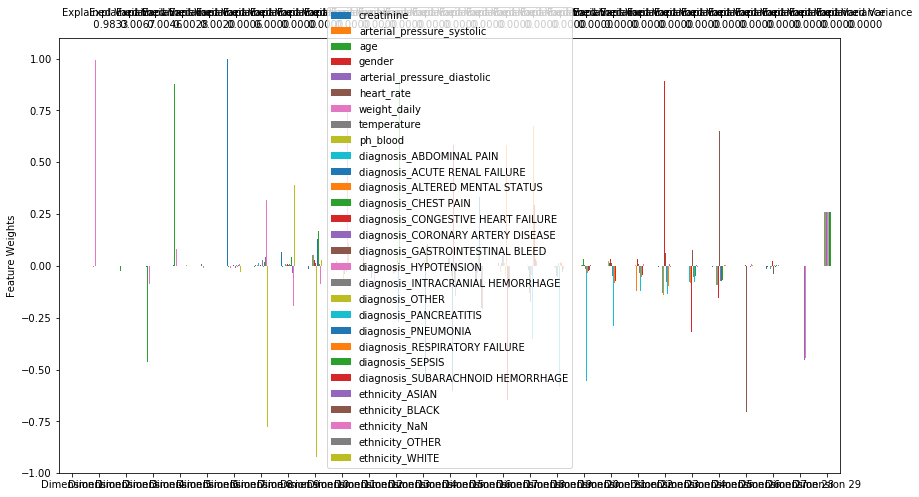

In [13]:
from sklearn.decomposition import PCA
import visuals as vs

pca = PCA(n_components = X.shape[1], random_state= 42).fit(X)

pca_results = vs.pca_results(X, pca)